In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import zipfile
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

2023-09-24 10:29:46.973464: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-24 10:29:46.976168: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 10:29:47.032184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 10:29:47.033022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 10:29:47.874879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [16]:
data_dir = '../../__DATASET__/dogs-vs-cats/'

image_dir = '../../__DATASET__/dogs-vs-cats/train/'

filename = os.listdir(image_dir)
label = [x.split(".")[0] for x in filename] # split each filename at the period

data = pd.DataFrame({"filename":filename, "label":label})
data.head(10)

,filename,label
0,dog.6857.jpg,dog
1,cat.12334.jpg,cat
2,cat.7110.jpg,cat
3,cat.5887.jpg,cat
4,cat.6278.jpg,cat
5,cat.6597.jpg,cat
6,cat.5772.jpg,cat
7,cat.2134.jpg,cat
8,dog.3991.jpg,dog
9,dog.8455.jpg,dog


In [29]:
filename[10]

'dog.5531.jpg'

In [26]:
filename[10].split(".")[0], filename[10].split(".")[1], filename[10].split(".")[2]

('dog', '5531', 'jpg')

### Checking for Data Imbalance and number of categories

In [9]:
data['label'].value_counts()

# data is balanced and has 2 categories

label
dog    12500
cat    12500
Name: count, dtype: int64

### Visualize the data for each category

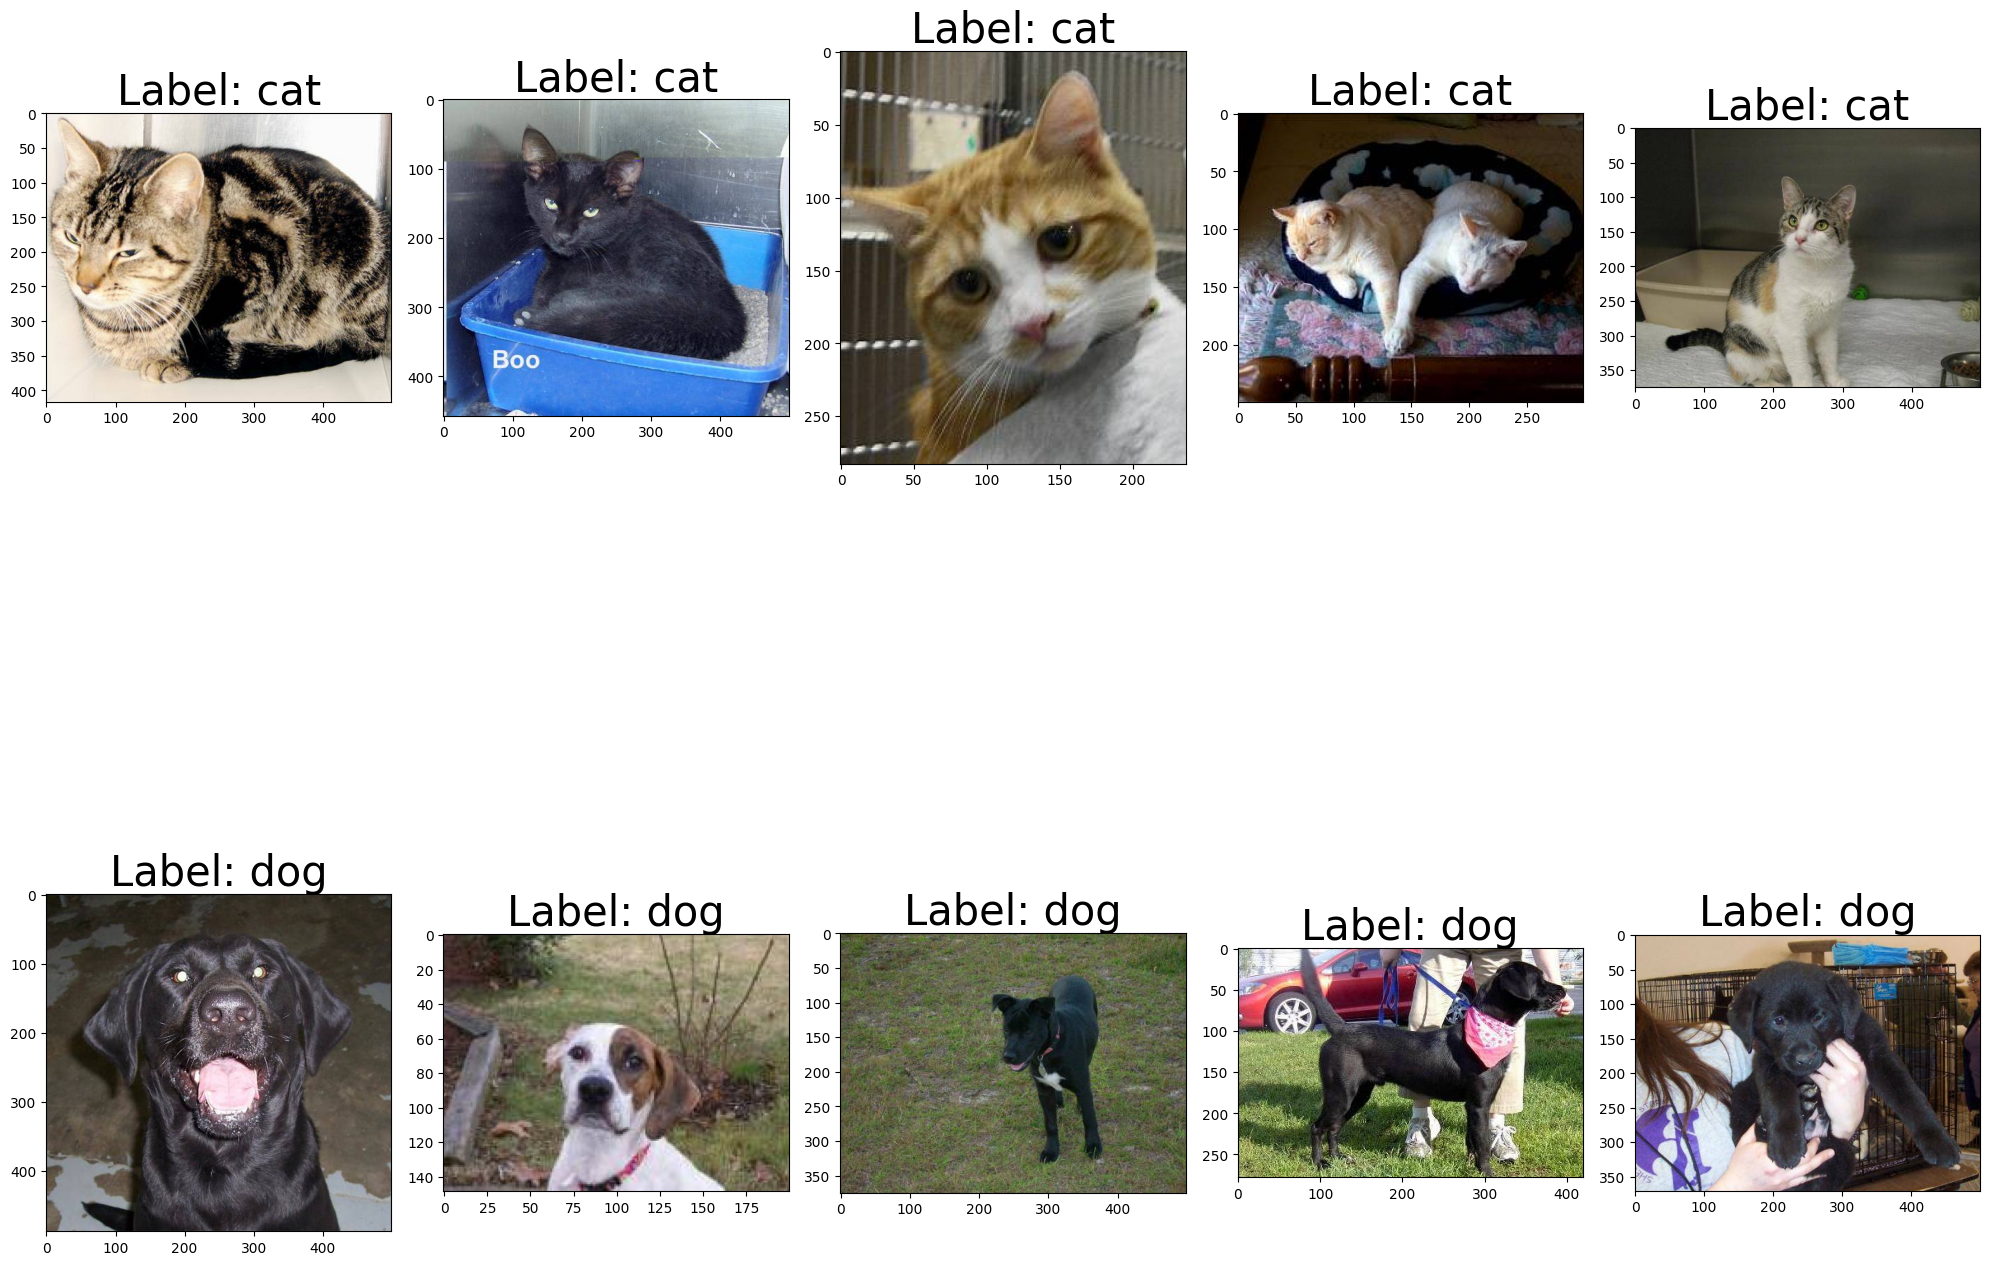

In [14]:
grouped_data = data.groupby("label")

num_images_per_category = 5

fig, axes = plt.subplots(len(grouped_data), num_images_per_category, figsize=(20, 20))

for i, (category, group) in enumerate(grouped_data):
  
    random_indices = random.sample(range(len(group)), num_images_per_category)

    for j, index in enumerate(random_indices):
        filename = group.iloc[index]["filename"]
        label = group.iloc[index]["label"]
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path)

        axes[i, j].imshow(image)
        axes[i, j].set_title("Label: " + label, fontsize = 30)

plt.tight_layout()
plt.show()

In [36]:
category, group = grouped_data

category, group

(('cat',
              filename label
  1      cat.12334.jpg   cat
  2       cat.7110.jpg   cat
  3       cat.5887.jpg   cat
  4       cat.6278.jpg   cat
  5       cat.6597.jpg   cat
  ...              ...   ...
  24993    cat.647.jpg   cat
  24994   cat.9602.jpg   cat
  24995   cat.4379.jpg   cat
  24998   cat.3801.jpg   cat
  24999  cat.10986.jpg   cat
  
  [12500 rows x 2 columns]),
 ('dog',
             filename label
  0      dog.6857.jpg   dog
  8      dog.3991.jpg   dog
  9      dog.8455.jpg   dog
  10     dog.5531.jpg   dog
  12     dog.1972.jpg   dog
  ...             ...   ...
  24986  dog.6098.jpg   dog
  24988  dog.8870.jpg   dog
  24990  dog.3813.jpg   dog
  24996  dog.2872.jpg   dog
  24997  dog.5268.jpg   dog
  
  [12500 rows x 2 columns]))

In [40]:
labels = data['label'] 

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state=23)

label_test_val = X_temp['label']
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state=23)
# stratify param splits the datset in a way that the proportion of values in the samples will be the same as the proportion provided with this parameters
print ('X_train:', X_train['label'].value_counts())

print ('X_val:', X_val['label'].value_counts())

print ('X_test:', X_test['label'].value_counts())

X_train: label
cat    10000
dog    10000
Name: count, dtype: int64
X_val: label
cat    1250
dog    1250
Name: count, dtype: int64
X_test: label
dog    1250
cat    1250
Name: count, dtype: int64


In [44]:
batch_size = 64
size = (370, 370)

idg = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_idg = idg.flow_from_dataframe(
    X_train, "../../__DATASET__/dogs-vs-cats/train/", x_col="filename", y_col="label",
    batch_size=batch_size,
    target_size=size
)


Found 20000 validated image filenames belonging to 2 classes.


In [45]:

valid_idg = idg.flow_from_dataframe(
    X_val, "../../__DATASET__/dogs-vs-cats/train/", x_col="filename", y_col="label",
    batch_size=batch_size,
    target_size=size,
    shuffle=False
)


Found 2500 validated image filenames belonging to 2 classes.


In [46]:

test_idg = idg.flow_from_dataframe(
    X_test, "../../__DATASET__/dogs-vs-cats/train/", x_col="filename", y_col="label",
    batch_size=batch_size,
    target_size=size,
    shuffle=False
)


Found 2500 validated image filenames belonging to 2 classes.


In [61]:
test_dir = "../../__DATASET__/dogs-vs-cats/test1/"

filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

test1_idg =  idg.flow_from_dataframe(test_data, "../../__DATASET__/dogs-vs-cats/test1/", x_col= "filename",y_col = 'label',
                                    batch_size = batch_size,
                                    target_size=size, shuffle = False)


Found 12500 validated image filenames belonging to 1 classes.


### VGG16 model

In [47]:
vgg16_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=((370, 370, 3))
)

2023-09-24 11:33:16.687868: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-09-24 11:33:16.687973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mr-freak
2023-09-24 11:33:16.687980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mr-freak
2023-09-24 11:33:16.688140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.86.5
2023-09-24 11:33:16.688173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.86.5
2023-09-24 11:33:16.688177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.86.5


58889256/58889256 [==============================] - 24s 0us/step


In [48]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 370, 370, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 370, 370, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 370, 370, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 185, 185, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 185, 185, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 185, 185, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 92, 92, 128)       0     

In [49]:
# Freeze the weights of all the layers in the model
for layer in vgg16_model.layers:
    layer.trainable = False


### Functional Model

In [50]:
flat = tf.keras.layers.Flatten()(vgg16_model.output)
dropout1 = tf.keras.layers.Dropout(0.2, name="Dropout1")(flat)
dense1 = tf.keras.layers.Dense(128, activation="relu")(dropout1)
dropout2 = tf.keras.layers.Dropout(0.2, name="Dropout2")(dense1)
output = tf.keras.layers.Dense(2, activation="softmax")(dropout2)

final_model = tf.keras.models.Model(inputs=[vgg16_model.input], outputs=[output])



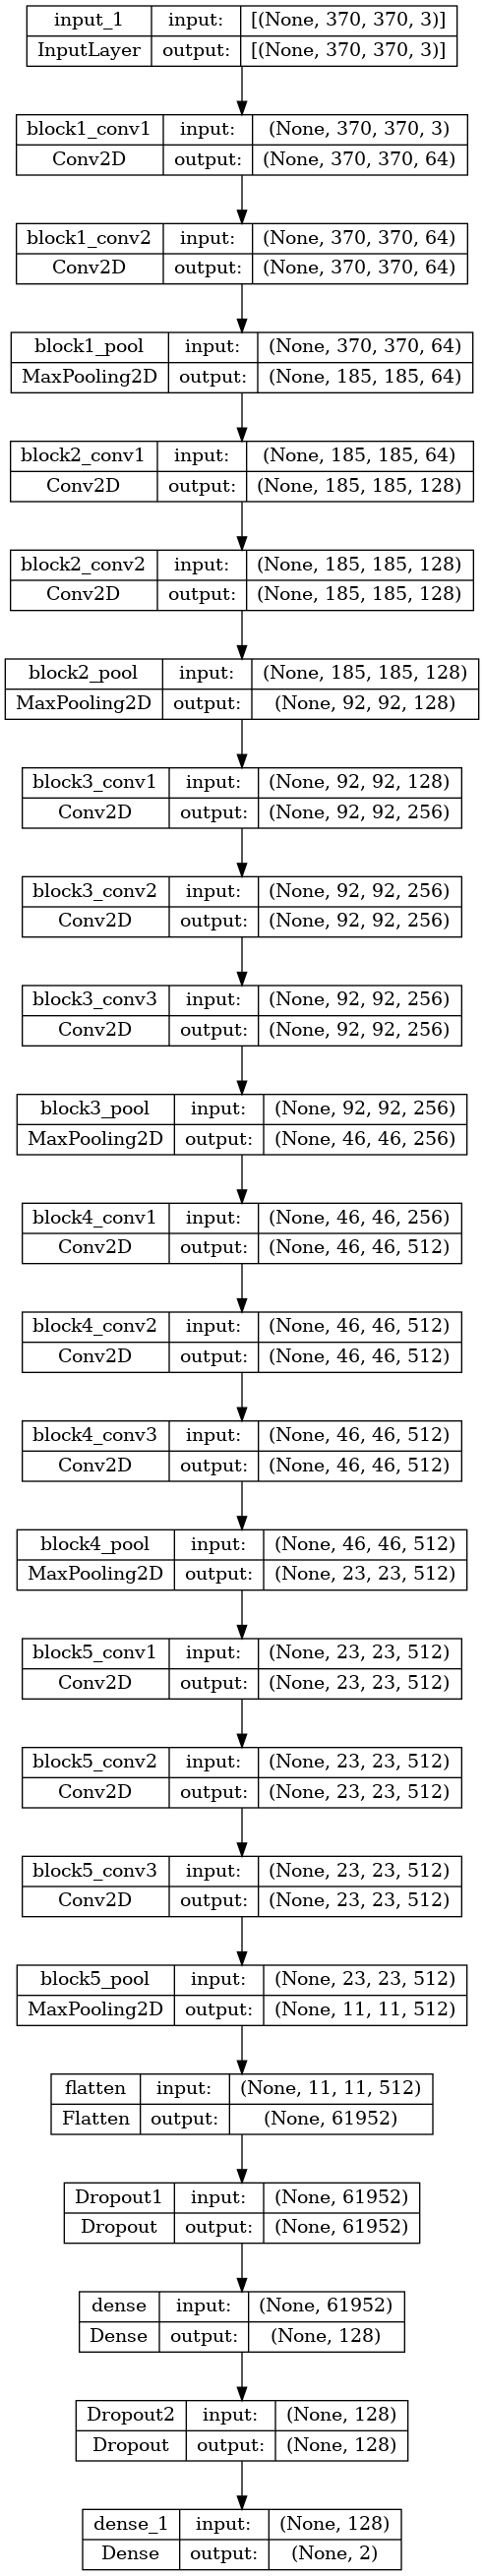

In [53]:
tf.keras.utils.plot_model(final_model, show_shapes=True, show_layer_names=True)

### Compile the model

In [54]:
final_model.compile(optimizer="adam",
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics=["acc"])


### Callback

In [55]:
model_ckpt = tf.keras.callbacks.ModelCheckpoint("DogCat",
                                                monitor="val_loss",
                                                save_best_only=True)

In [ ]:
history = final_model.fit(train_idg, batch_size=batch_size, 
                          validation_data=valid_idg, epochs = 8, 
                          callbacks=[model_ckpt])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
cat_dog_model = tf.keras.models.load_model("DogCat")

result = cat_dog_model.predict(test_idg)

result_argmax = np.argmax(result, axis=1)

y_true = test_idg.labels

y_pred = result_argmax

accuracy = (y_pred == y_true).mean()

print("Test Accuracy:", accuracy)

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
test1_predict = cat_dog_model.predict(test1_idg)

test1_predict_argmax = np.argmax(test1_predict, axis=1)

y_test_pred = test1_predict_argmax

test_data['label'] = y_test_pred

test_data.head()

In [ ]:
train_idg.class_indices

In [ ]:
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head()

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx in range(5):
    image_path = os.path.join(test_dir, test_data.iloc[idx]['filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title("Label: " + test_data.iloc[idx]['label'])
    axes[idx].axis('off')
plt.show()